Origonal Paper: https://www.nature.com/articles/s41567-020-0932-7

For Reference (state reconstruction and more): https://pennylane.ai/qml/demos/tutorial_classical_shadows/

For Reference (estimating observables): https://pennylane.ai/qml/demos/tutorial_diffable_shadows/

Import Modules

In [261]:
import numpy as np
import qutip

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import *
from qiskit.primitives import StatevectorSampler

Constructing the Classical Shadow

In [262]:
def construct_shadow (circuit, shadow_size, num_qubits):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    Given a quantum circuit, this function creates a collection of bitstrings generated by random single-qubit Pauli measurements and records the associated random pauli measurment.

    Args:
        circuit (QuantumCircuit): The quantum circuit which resulting state we wish to estimate.
        shadow_size (int): The number of random Pauli measurements to be taken.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        np.array: An array of shape (shadow_size, num_qubits) where each element is a tuple of the form (b, unitary_index) where b is the measured basis state in the computational basis and unitary_index is the index of the Pauli operator applied to the qubit.
    """

    # Array to store the classical shadow.
    shadow = np.zeros((shadow_size, num_qubits), dtype=object)

    # Local qubit unitaries. 
    phase_z = np.matrix([[1,0],[0,-1j]], dtype=complex)
    hadamard = np.matrix([[1,1],[1,-1]], dtype=complex)/np.sqrt(2)
    identity = np.matrix([[1,0],[0,1]], dtype=complex)

    # Rotations to measure each of the paulis.
    X = hadamard
    Y = hadamard @ phase_z
    Z = identity

    # Tomographically complete set of unitaries. (The pauli basis is tomographically complete.) 
    unitary_ensemble = [X, Y, Z]

    # Iterate over the number of shadows.
    for i in range(shadow_size):

        # Iterate over all the qubits in the circuit.
        for j in range(num_qubits):

            # Randomly select a unitary from the ensemble.
            unitary_index = np.random.randint(0,3)
            unitary = unitary_ensemble[unitary_index]

            # Apply the unitary to the qubit and measure in the computational basis.

            # The circuit below will apply the unitary to qubit j and measure it.
            qr = QuantumRegister(num_qubits, 'q')
            cr = ClassicalRegister(1, 'c')

            qc = QuantumCircuit(qr, cr)
            qc.append(UnitaryGate(unitary, "Rand_Pauli"), [j])
            qc.measure(j, 0)

            # Compose the measurment circuit with the input circuit.
            qc = circuit.compose(qc)

            # Instantiate a sampler that runs the cicuit once.
            sampler = StatevectorSampler(default_shots = 1)     
            # Run the sampler on the quantum circuit and store the result.
            result = sampler.run([qc]).result()[0]              

            # Store the counts for number of 0's and 1's measured in the computational basis.
            counts = result.data.c.get_counts()       

            # Get the measured basis state.
            if '0' in counts.keys():
                b = 0
            else:
                b = 1

            # Record the result of the measurement and the unitary applied.
            shadow[i,j] = (b, unitary_index)

    return shadow

State Reconstruction using a Classical Shadow

In [263]:
def reconstruct_from_shadow(shadow):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    Given a classical shadow, this function reconstructs an approximation of the density matrix of the quantum state.
    
    Args:
        shadow (np.array): An array of shape (shadow_size, num_qubits) where each element is a tuple of the form (b, unitary_index) where b is the measured basis state in the computational basis and unitary_index is the index of the Pauli operator applied to the qubit.

    Returns:
        np.array: An approximation of the density matrix of the quantum state.
    """

    # Size of the shadow and Number of qubits in the circuit.
    shadow_size, num_qubits = shadow.shape

    # Computational basis states.
    zero_state = np.matrix([[1,0],[0,0]], dtype=complex)
    one_state = np.matrix([[0,0],[0,1]], dtype=complex)

    # Local qubit unitaries. 
    phase_z = np.matrix([[1,0],[0,-1j]], dtype=complex)
    hadamard = np.matrix([[1,1],[1,-1]], dtype=complex)/np.sqrt(2)
    identity = np.matrix([[1,0],[0,1]], dtype=complex)

    # Rotations to measure each of the paulis.
    X = hadamard
    Y = hadamard @ phase_z
    Z = identity

    # Tomographically complete set of unitaries. (The pauli basis is tomographically complete.) 
    unitary_ensemble = [X, Y, Z]

    # For a multiqubit state we must apply the formula S44 from the preskill paper.

    # Array to store the estimated density matrix.
    rho_estimated = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

    for i in shadow:
        # Array to store the density matrix at each snapshot.
        rho_snapshot = [1]

        for j in i:
            
            # Implementation of formula S44 from the preskill paper.
            U = unitary_ensemble[j[1]]
            if j[0] == 0:
                b_state = zero_state
            else:
                b_state = one_state

            rho_local = 3*(U.H @ b_state @ U) - identity

            rho_snapshot = np.kron(rho_snapshot, rho_local)

        # Average all the inverted basis states to get an approximation of the density matrix.

        rho_estimated += rho_snapshot

    return rho_estimated/shadow_size

Testing the reconstruction routine

In [264]:
def operator_distance(A, B):
    """
    Calculate the distance between two operators using the frobenius norm.

    Args:
        A (np.array): The first operator.
        B (np.array): The second operator.

    Returns:
        float: The distance between the two operators.
    """

    return np.linalg.norm((A - B), ord = 'fro')

Test the reconstruction with a single qubit state.

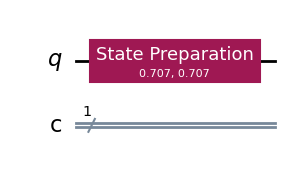

In [265]:
single_qubit_state = [1/np.sqrt(2), 1/np.sqrt(2)]

# Instantiate quantum and classical registers each of 1 bit.
single_qubit_qr = QuantumRegister (1, 'q')
single_qubit_cr = ClassicalRegister(1, 'c')

# Create a quantum circuit and add the prepare_state function acting on qubit 0.
single_qubit_qc = QuantumCircuit(single_qubit_qr, single_qubit_cr)
single_qubit_qc.prepare_state(state = single_qubit_state, qubits = 0)

# Draw the ciruit in mpl (matplotlib).
single_qubit_qc.draw("mpl")

In [266]:
shadow = construct_shadow(single_qubit_qc, 10, 1)
rho_estimated = reconstruct_from_shadow(shadow)
print(rho_estimated)

phi = np.matrix(single_qubit_state).T

rho_expected = phi @ phi.H
print(rho_expected)

print(operator_distance(rho_estimated, rho_expected))

[[0.5+0.j 0.6+0.j]
 [0.6+0.j 0.5+0.j]]
[[0.5 0.5]
 [0.5 0.5]]
0.14142135623730948


Test with a trivial 2 qubit state

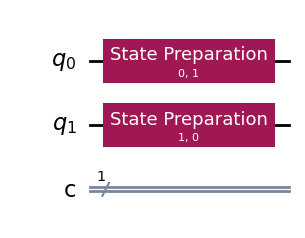

In [273]:
trivial_2_qubit_state = [0, 1, 0, 0]

# Instantiate quantum register of 2 bits and classical register of 1 bit.
trivial_2_qubit_qr = QuantumRegister(2, 'q')
trivial_2_qubit_cr = ClassicalRegister(1, 'c')

# Create a quantum circuit and add the prepare_state function acting on qubits 0 and 1.
trivial_2_qubit_qc = QuantumCircuit(trivial_2_qubit_qr, trivial_2_qubit_cr)
trivial_2_qubit_qc.prepare_state(state = [0,1], qubits=0)
trivial_2_qubit_qc.prepare_state(state = [1,0], qubits=1)

# Draw the circuit in mpl (matplotlib).
trivial_2_qubit_qc.draw('mpl')


In [275]:
shadow = construct_shadow(trivial_2_qubit_qc, 1000, 2)

rho_estimated = reconstruct_from_shadow(shadow)
print(rho_estimated)

phi = np.matrix(trivial_2_qubit_state).T

rho_expected = phi @ phi.H
print(rho_expected)

print(operator_distance(rho_estimated, rho_expected))

# Note the swapped entries. Between the rho_estimated and rho_expected. The 0.97 in the rho_estimaed should be where the 1 is in the rho_expected.

[[ 0.0295 +0.j       0.00675-0.03375j  0.036  +0.021j   -0.01575+0.00225j]
 [ 0.00675+0.03375j -0.02   +0.j      -0.02475-0.03825j  0.0045 +0.003j  ]
 [ 0.036  -0.021j   -0.02475+0.03825j  0.97   +0.j      -0.01575+0.06525j]
 [-0.01575-0.00225j  0.0045 -0.003j   -0.01575-0.06525j  0.0205 +0.j     ]]
[[0 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]]
1.41497738497829


Test with a 2 qubit state (bell state)

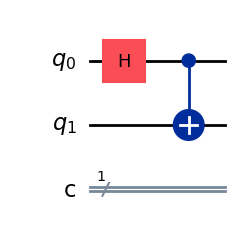

In [269]:
bell_state = [1/np.sqrt(2), 0, 0, 1/np.sqrt(2)]

# Instantiate quantum register of 2 bits and classical register of 1 bit.
bell_state_qr = QuantumRegister (2, 'q')
bell_state_cr = ClassicalRegister(1, 'c')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr, bell_state_cr)
bell_state_qc.append(
    HGate(),
    [0]
)
bell_state_qc.append(
    CXGate(),
    [0, 1]
)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [270]:
shadow = construct_shadow(bell_state_qc, 1000, 2)

print(shadow)

rho_estimated = reconstruct_from_shadow(shadow)
print(rho_estimated)

phi = np.matrix(bell_state).T

rho_expected = phi @ phi.H
print(rho_expected)

print(operator_distance(rho_estimated, rho_expected))

[[(0, 1) (0, 1)]
 [(1, 0) (0, 1)]
 [(0, 1) (0, 1)]
 ...
 [(0, 0) (0, 2)]
 [(0, 0) (1, 0)]
 [(0, 1) (0, 1)]]
[[ 0.28   +0.j       0.02625-0.02475j  0.009  -0.0015j  -0.00225-0.02475j]
 [ 0.02625+0.02475j  0.2665 +0.j       0.01575-0.02025j -0.0405 -0.0015j ]
 [ 0.009  +0.0015j   0.01575+0.02025j  0.2065 +0.j      -0.04575+0.01575j]
 [-0.00225+0.02475j -0.0405 +0.0015j  -0.04575-0.01575j  0.247  +0.j     ]]
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]
0.8624743474446064


Estimating Pauli Observables (using median of means estimation)

In [271]:
def estimate_observable(shadow, observable, k):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    
    """

It is instructive to know how many samples are required to bound the error of our estimator by $\epsilon$ for a given set of observables.

In [272]:
def shadow_bound(error, observables, failure_rate = 0.01):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    
    """

Compare the number of samples for error $\epsilon$ and compare it to the variance for the naive appoach of obtaining the expectation value of each observable by means of repeated projective measurements in the eigen basis of the observable. (I think this is the correct wording)